In [1]:
import os
import sys
import yaml
import torch
import tqdm
import numpy as np
from scipy.stats import gamma
import matplotlib.pyplot as plt

base_dir = os.path.join(os.getcwd(), '..')
sys.path.append(base_dir)

import src.preprocessing as preproc
from src.models import *

In [2]:
# Load config file
with open('../config/ideal.yaml', "r") as f:
    cfg = yaml.safe_load(f)
cfg['dataset']['path'] = '../data/aodisaggregation_emmisions_test_6.3_ACCMIP_200806.06_echam.nc'

# Load dataset
data = preproc.make_data(cfg=cfg, include_2d=False)

In [4]:
# Choose a calibration columns to evaluate model over
torch.random.manual_seed(cfg['evaluation']['calibration_seed'])
calib_idx = torch.randperm(len(data.h_by_column_std))[:100]

# Predict idealized exponential height profile
lbda = cfg['model']['lbda']
h_stddev = data.h_by_column.std()
prediction_3d = torch.exp(-lbda * data.h_by_column_std[calib_idx])

# Rescale predictions by τ/∫φdh
aggregate_prediction = h_stddev * (torch.exp(-lbda * data.h_by_column_std[:, -1]) - torch.exp(-lbda * data.h_by_column_std[:, 0])) / lbda
correction = data.z_smooth[calib_idx] / aggregate_prediction[calib_idx]
prediction_3d = prediction_3d.mul(correction.unsqueeze(-1))

In [5]:
# Rescale distribution variance without shifting mean
def make_bext_dist(prediction_3d, alpha):
    theta = prediction_3d.div(alpha)
    bext_dist = gamma(a=alpha, scale=theta)
    return bext_dist

# Compute calibration plots for given region sizes
def compute_calibrations(bext_dist, sizes):
    calibration = []
    mu = bext_dist.mean
    for size in sizes:
        q_lb = (1 - size) / 2
        q_ub = 1 - q_lb
        lb = torch.from_numpy(bext_dist.ppf(q_lb))
        ub = torch.from_numpy(bext_dist.ppf(q_ub))
        lb_mask = data.gt_by_column[calib_idx] > lb
        ub_mask = data.gt_by_column[calib_idx] < ub
        region_mask = lb_mask & ub_mask
        calibration.append(region_mask.float().mean().item())
    return np.asarray(calibration)

# Compute deviation from perfect calibration
def ICI(calibration, sizes):
    return np.abs(calibration - sizes).mean()

In [6]:
# Range of shapes for bext
alphas = np.arange(0.01, 1.5, 0.01)
alpha_iters = tqdm.notebook.tqdm(alphas)

# Confidence region sizes to consider
sizes = np.arange(0.05, 1.0, 0.2)


integrals = []
for alpha in alpha_iters:
    alpha_bext = torch.tensor(alpha)
    bext_dist = make_bext_dist(prediction_3d, alpha_bext)
    calibration = compute_calibrations(bext_dist, sizes)
    integrals.append(ICI(calibration, sizes))
integrals = np.asarray(integrals)

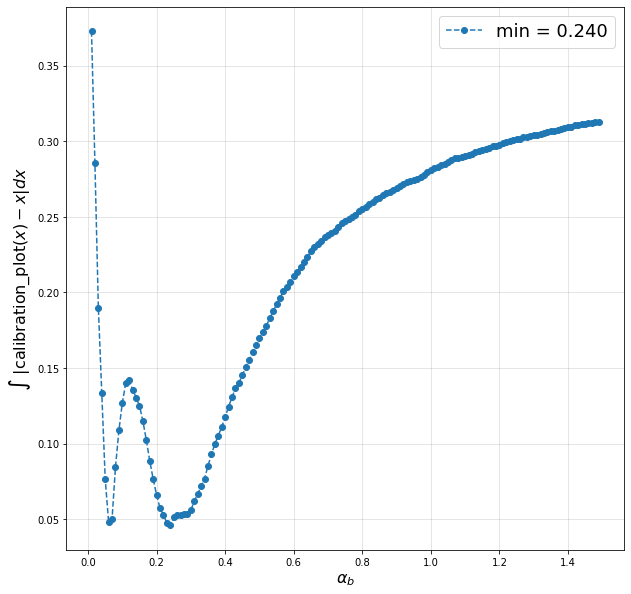

In [8]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))

best_shape = alphas[np.argmin(integrals)]
ax.plot(alphas, integrals, '--o', label=f'min = {best_shape:.3f}')

ax.set_xlabel(r'$\alpha_b$', fontsize=16)
ax.set_ylabel(r'$\int$ |calibration_plot$(x) - x|dx$ ', fontsize=16)
ax.grid(alpha=0.4)
plt.legend(fontsize=18)